# Feature Selection ad Hyperparameter tuning

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray
    !pip3 install xarray
    !pip3 install rasterio
    !pip3 install fiona
    !pip install matplotlib-scalebar
    !pip install plotnine

In [ ]:
import os
import importlib
import numpy as np
import pandas as pd

import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import (train_test_split, KFold, LeaveOneGroupOut,
                                     cross_validate, cross_val_predict, GridSearchCV)
from sklearn.feature_selection import RFECV, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             make_scorer)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from numpy import sqrt, mean, absolute

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir =  '/content/drive/MyDrive/Thesis/'

import sys
sys.path.append(os.path.join(base_dir, 'scripts'))

import modeling
importlib.reload(modeling)
from modeling import(Metrics, aggregate_feature_importance, SFS_with_GridSearch,
                     feature_groups)

import Config
importlib.reload(Config)
from Config import (
    df_corr_columns_to_drop, df_corr_Geo_columns, seasonal_variables,
    columns_to_drop, feature_groups_list, rf_predictor_list, svr_predictor_list,
    gbr_predictor_list,rename_preds_dict,)

from Utils import (
    plot_correlation_heatmap)


Database_gpkg = os.path.join(base_dir, 'Database.gpkg')
Model_data = os.path.join(base_dir, 'Model_data.gpkg')
print(f"Model_data: {fiona.listlayers(Model_data)}")
print(f"Database_gpkg: {fiona.listlayers(Database_gpkg)}")

Mounted at /content/drive
Model_data: ['plots_data', 'train_data', 'test_data', 'Final_data']
Database_gpkg: ['BHR1', 'BHW2', 'Wolfskehlen', 'Leinhardt', 'processed_data', 'processed_data_folds', 'Training_data', 'Validation_data', 'AOI_Hessen', 'AOI_wolf', 'Tectonics', 'Landkreis']


In [ ]:
def remove_negative(df):
    """
    Remove negative values from the DataFrame.
    """
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].clip(lower=0)

    return df

#Load data
train_data = gpd.read_file(Model_data, layer='train_data', driver='GPKG')
test_data = gpd.read_file(Model_data, layer='test_data', driver='GPKG')
Final_data= gpd.read_file(Model_data, layer='Final_data', driver='GPKG')

datasets = [train_data, test_data, Final_data]
dfp = []
for dataset in datasets:
  df=dataset.copy()
  df = dataset.drop(columns_to_drop, axis=1).rename(columns= {'Rn_Poten':'GRP'})
  df = remove_negative(df)
  dfp.append(df)

train_sample, test_sample, Final_sample = dfp[0], dfp[1], dfp[2]
_Final_sample=Final_sample.copy()
#print(Final_data.shape)
#print(Final_sample.shape)

In [ ]:
# helper functions

def scaled_data(unscaled_df):
    """
    Scale the data excluding specified columns.
    """
    data_to_scale = unscaled_df.copy()
    feature_to_exclude = 'grids_36k'
    features_to_scale = [col for col in data_to_scale.columns if col != feature_to_exclude]
    scaler = StandardScaler()
    data_to_scale[features_to_scale] = scaler.fit_transform(data_to_scale[features_to_scale])

    return data_to_scale

def drop_all_seasonal_values(scaled_data):
    """
    Drop columns identified as seasonal variables from the DataFrame.
    """
    #seasonal_variable = seasonal_variables.rename(columns=rename_preds_dict)
    scaled_multiannual = scaled_data.drop(seasonal_variables, axis=1)

    return scaled_multiannual

Final_sample = scaled_data(Final_sample).rename(columns=rename_preds_dict)
Final_sample_nonseasonal = drop_all_seasonal_values(scaled_data(_Final_sample)).rename(columns=rename_preds_dict)
X = Final_sample.iloc[:,1:]
y = _Final_sample["GRP"]

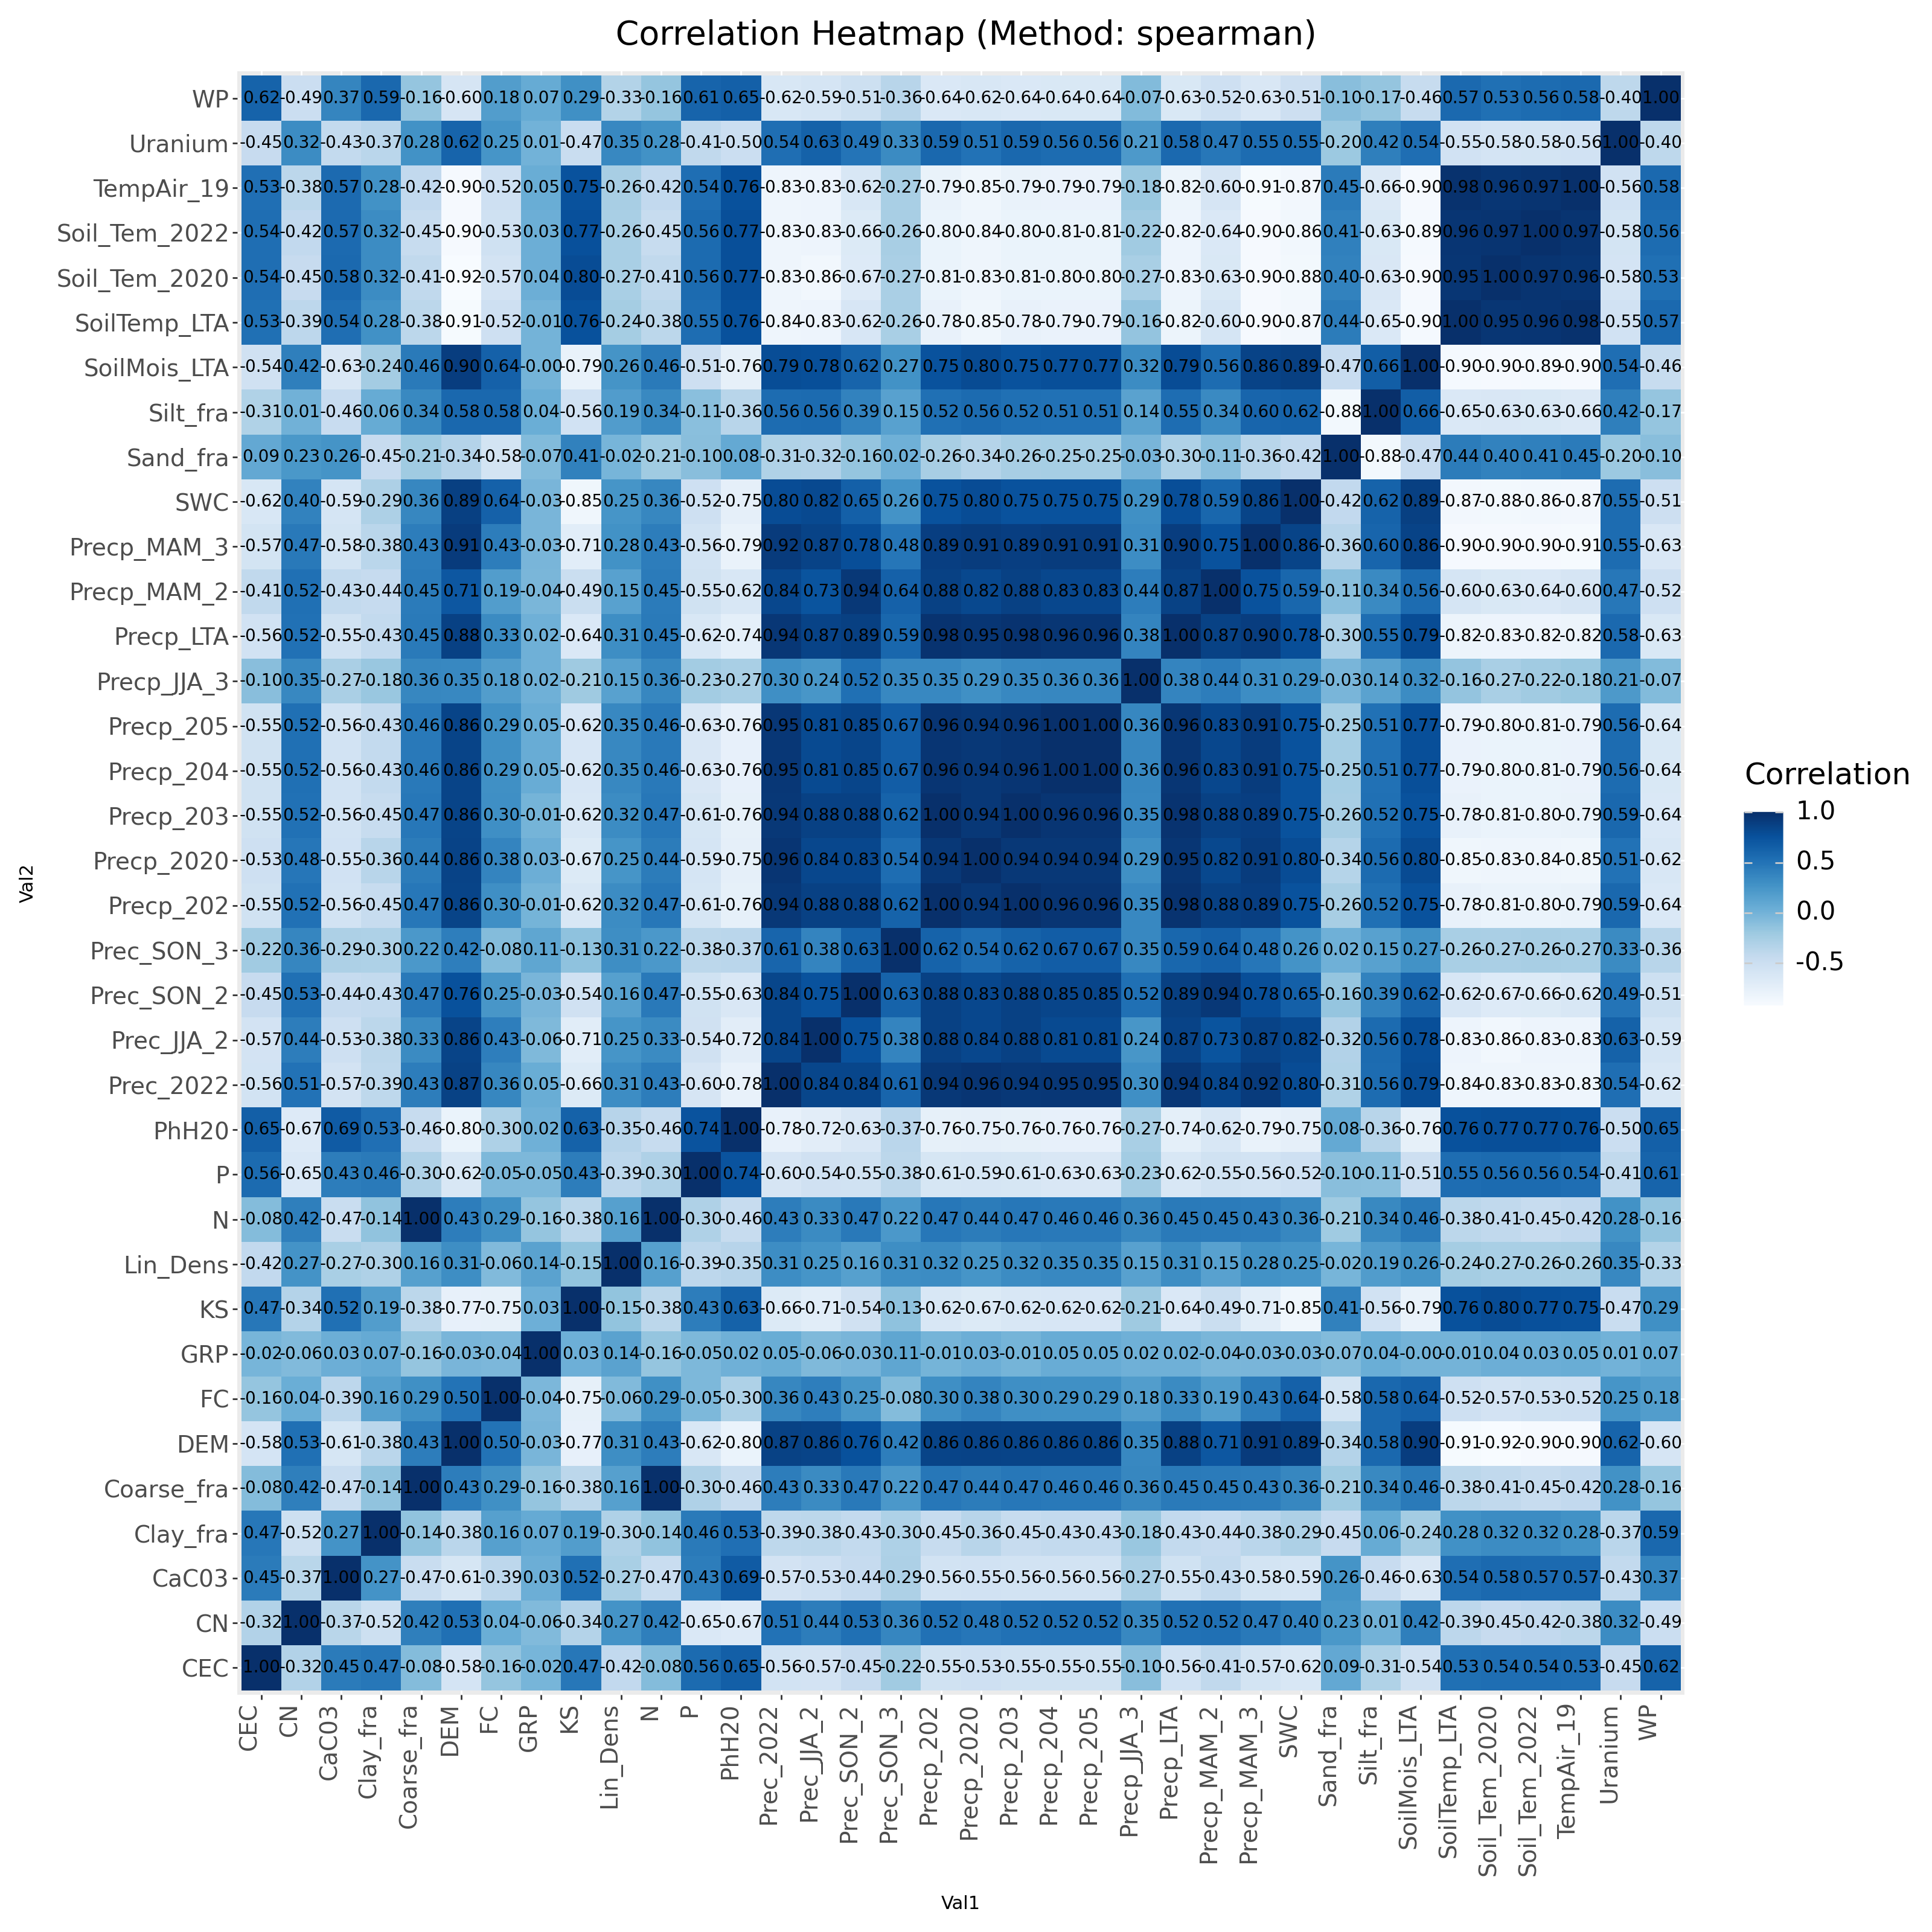

In [ ]:
# Plot correlation hatmap of predictors without geology

df_corr = Final_sample.drop(df_corr_columns_to_drop, axis=1)
df_corr_renamed = df_corr.rename(columns=rename_preds_dict)

plot_correlation_heatmap(df_corr_renamed,'spearman',figsize = (16, 16))

In [ ]:
feature_names=tuple(X.columns)
X.shape, y.shape
group_column='grids_36k'
target_column='GRP'

def feature_groups(dataframe, feature_groups_list):
    """
    Create a list of feature groups for the given DataFrame, where some features are grouped together.
    """
    filtered_dataframe = dataframe.drop(columns=['GRP', 'grids_36k'], axis=1)
    ungrouped_features = filtered_dataframe.drop(columns=feature_groups_list, axis=1)
    ungrouped_features_list = [
        [filtered_dataframe.columns.get_loc(col)] for col in ungrouped_features]

    grouped_features_tuple = [
        filtered_dataframe.columns.get_loc(col) for col in feature_groups_list
    ]
    grouped_features_list = [grouped_features_tuple]

    # Combine ungrouped and grouped features
    feature_group_all = ungrouped_features_list + grouped_features_list

    return feature_group_all

feature_group = feature_groups(Final_sample, feature_groups_list )
feature_group_seasonal = feature_groups(Final_sample_nonseasonal, feature_groups_list )

def aggregate_feature_importance(importance_df, feature_groups_list):
    """
    Grouped feature importance to sum the Geology features
    """
    # Aggregate grouped feature importance
    fimp_index = importance_df.set_index('Feature')
    aggregated_values = fimp_index.loc[feature_groups_list].sum()
    new_row = pd.DataFrame({
        'Feature': 'Geology',
        'Model Importance': [aggregated_values['Model Importance']],
        'Permutation Importance': [aggregated_values['Permutation Importance']]})

    importance_df = pd.concat([importance_df[~importance_df['Feature'].isin(
        feature_groups_list)], new_row], ignore_index=True)
    return importance_df.sort_values(by='Model Importance',
                                     ascending=False).reset_index(
                                         drop=True)


## Sequential Feature selection

# RF

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=1)]: Do

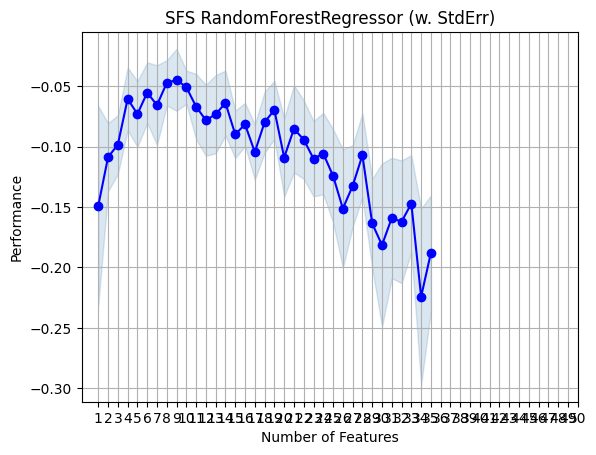

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20],
    'oob_score':[True,False],
}
fig_rf, selected_features_rf, sfs_metrics_rf, feature_importances_rf, best_estimator_rf = SFS_with_GridSearch(
    Final_sample,
    target_column=target_column,
    target_variable=_Final_sample[target_column],
    group_column=group_column,
    base_estimator=RandomForestRegressor(),
    param_grid=param_grid,
    feature_groups_list=feature_groups_list
)


In [ ]:
sfs_metrics_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(21,)","[-0.041014503785422596, -0.4549877266205742, 0...",-0.148803,"(Precp_MAM_2,)",0.212207,0.165105,0.082552
2,"(12, 21)","[-0.05025793043004634, -0.19295023952761325, -...",-0.108607,"(Lin_Dens, Precp_MAM_2)",0.072193,0.056169,0.028084
3,"(10, 12, 21)","[-0.05119508823070529, -0.17432364722722493, -...",-0.098285,"(SWC, Lin_Dens, Precp_MAM_2)",0.06269,0.048775,0.024387
4,"(9, 10, 12, 21)","[-0.03285566639957049, -0.01260277710507185, -...",-0.060348,"(KS, SWC, Lin_Dens, Precp_MAM_2)",0.066698,0.051893,0.025947
5,"(3, 9, 10, 12, 21)","[-0.07569204474065305, -0.10973125058647248, -...",-0.072916,"(CN, KS, SWC, Lin_Dens, Precp_MAM_2)",0.069707,0.054234,0.027117
6,"(3, 8, 9, 10, 12, 21)","[-0.05740402890624363, -0.07758278025630072, 0...",-0.055209,"(CN, FC, KS, SWC, Lin_Dens, Precp_MAM_2)",0.064618,0.050275,0.025137
7,"(3, 8, 9, 10, 12, 18, 21)","[-0.11444243958219391, -0.04441816741374294, -...",-0.06551,"(CN, FC, KS, SWC, Lin_Dens, Prec_2022, Precp_M...",0.084803,0.065979,0.03299
8,"(3, 7, 8, 9, 10, 12, 18, 21)","[-0.06508972837432236, -0.09958674995865646, -...",-0.047151,"(CN, DEM, FC, KS, SWC, Lin_Dens, Prec_2022, Pr...",0.048253,0.037543,0.018771
9,"(3, 7, 8, 9, 10, 12, 18, 21, 22)","[-0.09777430952668209, -0.10557948586913324, 0...",-0.044601,"(CN, DEM, FC, KS, SWC, Lin_Dens, Prec_2022, Pr...",0.065821,0.051211,0.025605
10,"(3, 7, 8, 9, 10, 12, 18, 21, 22, 24)","[-0.05255496818567473, -0.035395437979529376, ...",-0.05071,"(CN, DEM, FC, KS, SWC, Lin_Dens, Prec_2022, Pr...",0.03544,0.027573,0.013787


In [ ]:
feature_importances_rf

      Feature  Importance
0          WP       0.174
1        Geol       0.122
2       PhH20       0.121
3          FC       0.117
4           N       0.092
5         DEM       0.091
6  Lin_Densit       0.089
7         CEC       0.068
8    Sand_fra       0.062
9    Silt_fra       0.062


In [ ]:
best_estimator_rf

RandomForestRegressor(max_depth=10, n_estimators=50)

# SVR

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Do

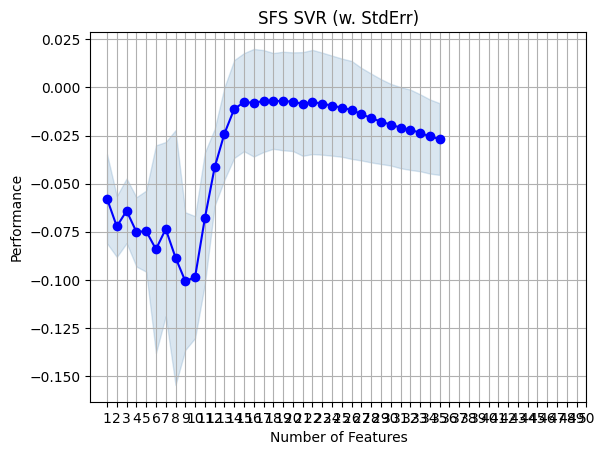

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Initialize SVR model
svr_grid = SVR(kernel='rbf')

# Reduced parameter grid for faster search
param_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'gamma': [0.001, 0.01, 0.1, 1]
}


fig_svr, selected_features_svr, sfs_metrics_svr, feature_importances_svr, best_estimator_svr = SFS_with_GridSearch(
    Final_sample,
    target_column=target_column,
    target_variable=_Final_sample[target_column],
    group_column=group_column,
    base_estimator=svr_grid,
    param_grid=param_svr,
    feature_groups_list=feature_groups_list
)


In [ ]:
sfs_metrics_svr

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(15,)","[-0.057821275976982944, -0.06865099618139525, ...",-0.057844,"(Sand_fra,)",0.059626,0.046391,0.023196
2,"(15, 34)","[-0.0870889122228975, -0.03452605983091028, -0...",-0.072267,"(Sand_fra, Uranium)",0.040669,0.031642,0.015821
3,"(15, 30, 34)","[-0.11930696983465494, -0.07899976873471037, -...",-0.064108,"(Sand_fra, Soil_Tem_2022, Uranium)",0.043197,0.033609,0.016804
4,"(12, 15, 30, 34)","[-0.07267656109679388, -0.1302315340996698, -0...",-0.075061,"(Lin_Dens, Sand_fra, Soil_Tem_2022, Uranium)",0.046283,0.03601,0.018005
5,"(12, 15, 30, 33, 34)","[-0.05374399483178194, -0.07943546560242876, -...",-0.074692,"(Lin_Dens, Sand_fra, Soil_Tem_2022, TempAir_19...",0.054154,0.042134,0.021067
6,"(8, 12, 15, 30, 33, 34)","[0.02105394510430758, -0.020215608229682935, -...",-0.084093,"(FC, Lin_Dens, Sand_fra, Soil_Tem_2022, TempAi...",0.138811,0.107999,0.054
7,"(8, 12, 15, 29, 30, 33, 34)","[0.011520993187822959, -0.019724318452272627, ...",-0.073611,"(FC, Lin_Dens, Sand_fra, Soil_Tem_2020, Soil_T...",0.116345,0.09052,0.04526
8,"(8, 12, 15, 29, 30, 32, 33, 34)","[0.017977011015405386, -0.008847013372576207, ...",-0.088422,"(FC, Lin_Dens, Sand_fra, Soil_Tem_2020, Soil_T...",0.170182,0.132407,0.066204
9,"(8, 10, 12, 15, 29, 30, 32, 33, 34)","[-0.07651572730349843, -0.08183882901259709, -...",-0.10067,"(FC, SWC, Lin_Dens, Sand_fra, Soil_Tem_2020, S...",0.091957,0.071546,0.035773
10,"(8, 10, 11, 12, 15, 29, 30, 32, 33, 34)","[-0.05351834781051612, -0.16555849423254965, -...",-0.098599,"(FC, SWC, WP, Lin_Dens, Sand_fra, Soil_Tem_202...",0.081506,0.063415,0.031707


In [ ]:
print(feature_importances_svr)

      Feature  Importance
0        Geol      40.741
1    Coarse_p      29.289
2           N      29.289
3          WP       7.445
4       CaC03       4.822
5  Lin_Densit       3.343
6           P       3.093
7    Clay_fra       2.191
8  Precip_LTA       1.863
9          CN       1.668


In [ ]:
best_estimator_svr

SVR(C=100, epsilon=0.001, gamma=1)

# GBR

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Do

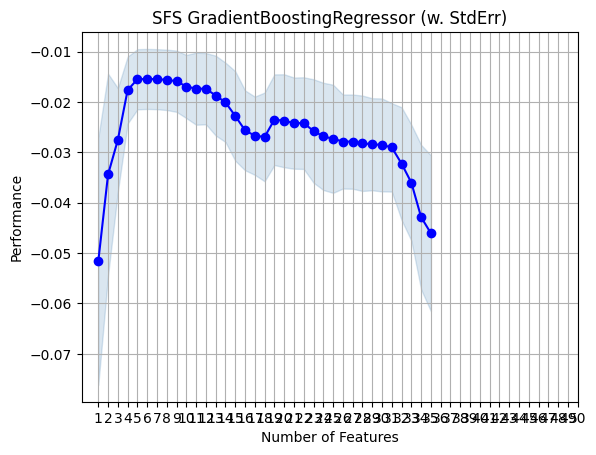

In [ ]:
# Define the parameter grid for GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor # Import the GradientBoostingRegressor class

#gbr_sfs = GradientBoostingRegressor(n_estimators=100, max_depth=None, learning_rate=0.1) # Now you can use it

param_grid_gbr = {
    'n_estimators':[100, 200, 300,500,1000],
    'learning_rate': [0.0001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7,10],
}

# Initialize GradientBoostingRegressor and GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)

fig_gbr, selected_features_gbr, sfs_metrics_gbr, feature_importances_gbr, best_estimator_gbr = SFS_with_GridSearch(
    Final_sample,
    target_column=target_column,
    target_variable=_Final_sample[target_column],
    group_column=group_column,
    base_estimator=gbr,
    param_grid=param_grid_gbr,
    feature_groups_list=feature_groups_list
)


In [ ]:
sfs_metrics_gbr

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(23,)","[0.027821738599851153, -0.07161303923521545, -...",-0.051632,"(Prec_SON_2,)",0.063066,0.049068,0.024534
2,"(23, 27)","[0.012655129363368323, -0.05180509182577131, -...",-0.034402,"(Prec_SON_2, Precp_204)",0.051388,0.039981,0.019991
3,"(12, 23, 27)","[8.492958800943029e-05, -0.04551708567885515, ...",-0.027537,"(Lin_Dens, Prec_SON_2, Precp_204)",0.026423,0.020558,0.010279
4,"(3, 12, 23, 27)","[0.006516151240093193, -0.03205592508464572, -...",-0.017655,"(CN, Lin_Dens, Prec_SON_2, Precp_204)",0.017073,0.013283,0.006642
5,"(3, 6, 12, 23, 27)","[0.008032599956859454, -0.025156968752464204, ...",-0.015512,"(CN, PhH20, Lin_Dens, Prec_SON_2, Precp_204)",0.015349,0.011942,0.005971
6,"(3, 6, 12, 23, 27, 28)","[0.008032599956859454, -0.025156968752464204, ...",-0.015443,"(CN, PhH20, Lin_Dens, Prec_SON_2, Precp_204, P...",0.015309,0.011911,0.005956
7,"(3, 6, 12, 18, 23, 27, 28)","[0.008030044574149686, -0.024801708972049585, ...",-0.015495,"(CN, PhH20, Lin_Dens, Prec_2022, Prec_SON_2, P...",0.015313,0.011914,0.005957
8,"(3, 6, 12, 18, 21, 23, 27, 28)","[0.008030044574149686, -0.025055316362449398, ...",-0.015623,"(CN, PhH20, Lin_Dens, Prec_2022, Precp_MAM_2, ...",0.01541,0.01199,0.005995
9,"(3, 6, 12, 17, 18, 21, 23, 27, 28)","[0.007946462780859198, -0.025997036748894864, ...",-0.0159,"(CN, PhH20, Lin_Dens, Precp_2020, Prec_2022, P...",0.015616,0.01215,0.006075
10,"(3, 6, 12, 17, 18, 21, 22, 23, 27, 28)","[0.007946462780859198, -0.025997036748894864, ...",-0.016952,"(CN, PhH20, Lin_Dens, Precp_2020, Prec_2022, P...",0.016111,0.012535,0.006268


In [ ]:
feature_importances_gbr

    Feature  Importance
0      Geol      47.408
1  Coarse_p      13.100
2         N      12.900
3     CaC03      12.850
4        WP       9.300
5  Clay_fra       7.910
6        CN       3.730
7         P       2.810
8        FC       2.670
9  Sand_fra       2.440


In [ ]:
best_estimator_gbr

GradientBoostingRegressor(learning_rate=0.01, random_state=42)

# Post Hyperparameter tuning

In [ ]:
_X = X.drop(columns= [group_column], axis=1)
# Define hyperparameter grids
param_grid_rf = {'n_estimators': [100, 500, 1000],'max_depth': [None, 10, 20],
                 'oob_score': [True, False]}
param_grid_svr = { 'model__C': [0.1, 1, 10],'model__epsilon': [0.01, 0.1, 1],
                   'model__gamma': ['scale',0.0001, 0.1, 1]}
param_grid_gbrt = {'n_estimators': [100, 200, 1000], 'learning_rate': [0.01, 0.1],
                   'max_depth': [3, 5, 7]}
param_grid_mlpr = {'model__hidden_layer_sizes': [(50,), (100,), (50, 50, 50)],
                  'model__activation': ['relu', 'tanh'],
                  'model__solver': ['adam',],
                  'model__learning_rate': ['constant', 'adaptive'],
                  'model__max_iter': [200, 500, 100000], }

models = {
    "RandomForest": (RandomForestRegressor(random_state=42), param_grid_rf),
    "SVR": (Pipeline([('scaler', StandardScaler()), ('model', SVR())]), param_grid_svr),
    "GBRT": (GradientBoostingRegressor(random_state=42), param_grid_gbrt),
    "MLPR": (Pipeline([('scaler', StandardScaler()), ('model', MLPRegressor(
        alpha=0.0001, random_state=42))]), param_grid_mlpr),}


scorer = make_scorer(mean_squared_error, greater_is_better=False)
best_models = {}
for model_name, (model, param_grid) in models.items():
    print(f"Running GridSearch for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorer,
        cv=5,
        verbose=10,
        n_jobs=-1)

    grid_search.fit(_X, y)
    best_models[model_name] = {
        "Best Params": grid_search.best_params_,
        "Best Score": -grid_search.best_score_ }

for model_name, results in best_models.items():
    print(f"\n{model_name}:")
    print(f"Best Parameters: {results['Best Params']}")
    print(f"Best Score (MSE): {results['Best Score']:.4f}")

Running GridSearch for RandomForest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Running GridSearch for SVR...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Running GridSearch for GBRT...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Running GridSearch for MLPR...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


RandomForest:
Best Parameters: {'max_depth': 10, 'n_estimators': 1000, 'oob_score': True}
Best Score (MSE): 1306.8654

SVR:
Best Parameters: {'model__C': 1, 'model__epsilon': 1, 'model__gamma': 0.0001}
Best Score (MSE): 1336.0339

GBRT:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000}
Best Score (MSE): 1266.9650

MLPR:
Best Parameters: {'model__activation': 'tanh', 'model__hidden_layer_sizes': (50,50,50), 'model__learning_rate': 0.01, 'model__max_iter': 100000, 'model__solver': 'adam'}
Best Score (MSE): 1387.6722)
